# Creation of new elements

SolidsPy supports user elements, that is, you can pass a function that returns
the mass and stiffness matrices for your element to the assembly operator.

This example shows how to create an element for membrane deflection.

## Equation to solve

We want to find the vibration modes of vibration modes of a thin membrane. This
is described by the Helmholtz equation

$$\nabla^2 u + k^2 u = 0\quad \forall \mathbf{x} \in \Omega\, .$$

The weak form for this problem is

$$
\int_\Omega \nabla u \cdot \nabla u \mathrm{d}\Omega
= k^2 \int_\Omega u^2 \mathrm{d}\Omega\, .
$$

And the discretized system is given by

$$[K]\{U\} = k^2[M]\{U\}\, .$$


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh, eigs,lobpcg
import meshio
import solidspy.assemutil as ass
import solidspy.femutil as fem
import solidspy.gaussutil as gau
import solidspy.postprocesor as pos

## Elemental matrices

We approximate the solution as

$$u \approx \mathbf{N}^T \mathbf{u}\, ,$$

where $\mathbf{N}^T = [N_0(x, y), N_1(x, y), \cdots, N_n(x, y)]$ is
the matrix with interpolators,
$\mathbf{u}^T = [u_0(x, y), u_1(x, y), \cdots, u_n(x, y)]$ the
matrix with displacements, and $n$ is the number of nodes in each
element.

The local mass and stiffness matrices are given by

\begin{align}
&[M_e] = \int_{\Omega_e} \mathbf{N} \mathbf{N}^T \mathrm{d}x \mathrm{d}y\, ,\\
&[K_e] = \int_{\Omega_e} \mathbf{B} \mathbf{B}^T \mathrm{d}x \mathrm{d}y\, ,
\end{align}

$\mathbf{B}$ is the matrix with the gradient of function at each node.


The function `acoust_diff` returns the interpolation matrix $\mathbf{N}$,
the interpolation derivatives matrix $\mathbf{B}$, and determinant for an
element evaluated at a point in local coordinates $(r, s)$.

In [3]:
def acoust_diff(r, s, coord, element):
    """
    Interpolation matrices for elements for acoustics

    Parameters
    ----------
    r : float
        Horizontal coordinate of the evaluation point.
    s : float
        Vertical coordinate of the evaluation point.
    coord : ndarray (float)
        Coordinates of the element.

    Returns
    -------
    H : ndarray (float)
        Array with the shape functions evaluated at the point (r, s)
        for each degree of freedom.
    B : ndarray (float)
        Array with the gradient matrix evaluated
        at the point (r, s).
    det : float
        Determinant of the Jacobian.
    """
    N, dNdr = element(r, s)
    N.shape = 1, N.shape[0]
    det, jaco_inv = fem.jacoper(dNdr, coord)
    dNdx = jaco_inv @ dNdr
    return N, dNdx, det

Using the function `acoust_diff` we could compute local mass and stiffness matrices.
The function `acoust_tri6` returns these local matrices for a quadratic triangular
element (6 nodes). As input arguments is take the coordinates of the nodes and
material parameters, speed of the wave in this case.

In [4]:
def acoust_tri6(coord, params):
    """
    Triangular element with 6 nodes for acoustics under
    axisymmetric conditions.

    Parameters
    ----------
    coord : coord
        Coordinates of the element.
    params : list
        List with material parameters in the following order:
        [Speed].

    Returns
    -------
    stiff_mat : ndarray (float)
        Local stifness matrix.
    mass_mat : ndarray (float)
        Local mass matrix.
    """
    
    speed = params
    stiff_mat = np.zeros((6, 6))
    mass_mat = np.zeros((6, 6))
    gpts, gwts = gau.gauss_tri(order=3)
    for cont in range(gpts.shape[0]):
        r = gpts[cont, 0]
        s = gpts[cont, 1]
        H, B, det = acoust_diff(r, s, coord, fem.shape_tri6)
        factor = det * gwts[cont]
        stiff_mat += 0.5 * speed**2 * factor * (B.T @ B)
        mass_mat += 0.5 * factor * (H.T @ H)
    return stiff_mat, mass_mat

## Assembly of system of equations

We need to read the mesh that is in the file `square.msh`.

In [5]:
mesh = meshio.read("square.msh")
points = mesh.points
cells = mesh.cells
tri6 = cells["triangle6"]
line3 = cells["line3"]
npts = points.shape[0]
nels = tri6.shape[0]

We define the nodes array.

In [6]:
nodes = np.zeros((npts, 3))
nodes[:, 1:] = points[:, 0:2] 

And the constraints array.

In [7]:
line_nodes = list(set(line3.flatten()))
cons = np.zeros((npts, 1), dtype=int)
cons[line_nodes, :] = -1

For the elements array we don't need to use the first three columns since
we are going to tell the assembly function to use our own function
to compute the matrices.

In [9]:
elements = np.zeros((nels, 9), dtype=int)
elements[:, 1] = 2
elements[:, 3:] = tri6

In [10]:
mats = np.array([[1.0]])

In [11]:
assem_op, bc_array, neq = ass.DME(cons, elements,
                                  ndof_node=1, ndof_el_max=6)

In [12]:
stiff_mat, mass_mat = ass.assembler(elements, mats, nodes, neq,
                                    assem_op, uel=acoust_tri6)

## Solution of the eigenvalue problem

In [13]:
eigvals, eigvecs = eigsh(stiff_mat, M=mass_mat, k=10, which="LM",
                         sigma=1e-6)

In [14]:
eigvals

array([ 2.00000007,  5.00000066,  5.0000012 ,  8.0000045 , 10.00000638,
       10.00000638, 13.00001214, 13.00002403, 17.00002827, 17.00002928])

This problem has as analytical solution

$$k^2 = m^2 + n^2\quad \forall m, n\in \mathbb{N}\, .$$

In [15]:
eigvals_exact = np.array(sorted([m**2 + n**2
                                 for m in range(1, 10)
                                 for n in range(1, 10)])[:10])
eigvals_exact

array([ 2,  5,  5,  8, 10, 10, 13, 13, 17, 17])

We can check if the computed eigenvalues are close to the analytical ones using
`np.allclose`.

In [17]:
np.allclose(eigvals, eigvals_exact)

True

And compare them in a plot.

<IPython.core.display.Javascript object>


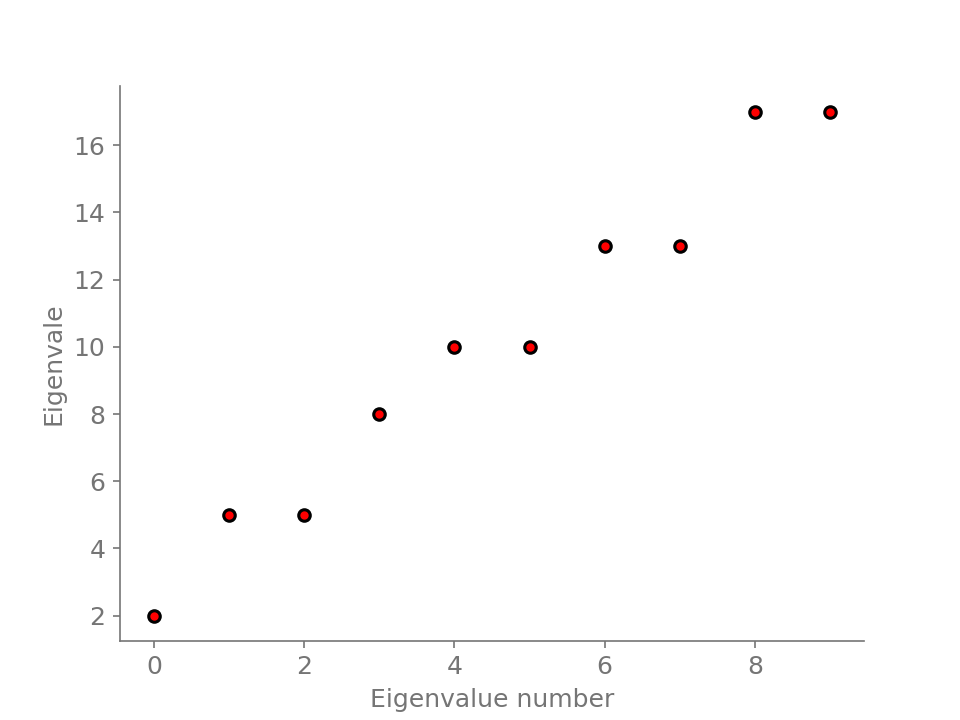

Text(0, 0.5, 'Eigenvale')

In [22]:
plt.plot(eigvals_exact, "ko")
plt.plot(eigvals, "r.")
plt.xlabel("Eigenvalue number")
plt.ylabel("Eigenvale")

## Visualization

Let us visualize the first vibration mode. For that we first need to complete
the solution vector with `pos.complete_disp` and then `pos.plot_node_field`.

In [44]:
sol = pos.complete_disp(bc_array, nodes, eigvecs[:, 0], ndof_node=1)

<IPython.core.display.Javascript object>


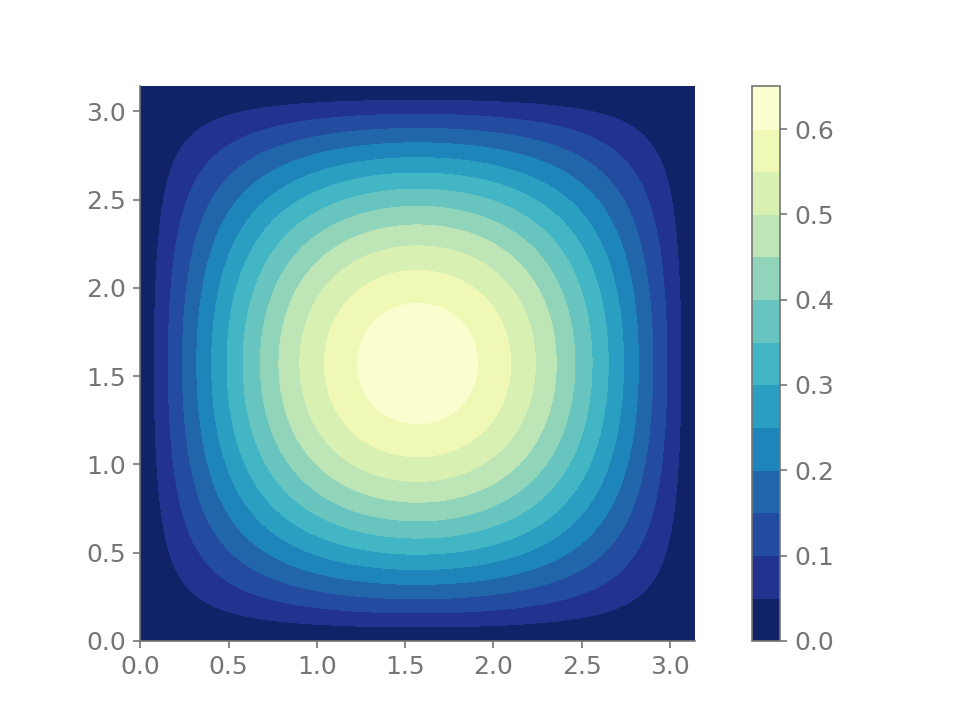

In [45]:
pos.plot_node_field(sol[:, 0], nodes, elements)

Finally, we can complete all the eigenvectors and export the results to a 
VTK file.

In [46]:
for cont in range(10):
    aux = pos.complete_disp(bc_array, nodes, eigvecs[:, cont],
                      ndof_node=1)
    mesh.point_data["mode_%d" % cont] = aux

meshio.write("membrane.vtk", mesh)